[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyPartMC/blob/main/examples/particle_simulation.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyPartMC/blob/main/examples/particle_simulation.ipynb)    
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyPartMC.git/main?urlpath=lab/tree/examples/particle_simulation.ipynb)    
[![ARM JupyterHub](https://img.shields.io/static/v1?label=launch%20in&logo=jupyter&color=lightblue&message=ARM+JupyterHub)](https://jupyterhub.arm.gov/hub/user-redirect/git-pull?repo=https%3A//github.com/open-atmos/PyPartMC&branch=main&urlPath=) (requires [logging in with ARM account](https://www.arm.gov/capabilities/computing-resources) and directing Jupyter to a notebook within the cloned repo)

In [1]:
# This file is a part of PyPartMC licensed under the GNU General Public License v3
# Copyright (C) 2023 University of Illinois Urbana-Champaign
# Authors:
#  - https://github.com/compdyn/partmc/graphs/contributors
#  - https://github.com/open-atmos/PyPartMC/graphs/contributors

### Urban plume simulation: based on Riemer et al. 2009 (JGR) "Simulating the evolution of soot mixing state with a particle‐resolved aerosol model."

https://doi.org/10.1029/2008JD011073

This simulation shows the evolution of carbonaceous aerosols from different emission types
in an idealized urban plume case representative of a large urban area. This notebook also provides a
step-by-step description of how to set up and run other user-defined PyPartMC simulations.

In [2]:
import sys
import os
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyPartMC')
elif 'JUPYTER_IMAGE' in os.environ and '.arm.gov' in os.environ['JUPYTER_IMAGE']:
    !pip --quiet install PyPartMC open_atmos_jupyter_utils
    _pypartmc_path = !pip show PyPartMC | fgrep Location | cut -f2 -d' '
    sys.path.extend(_pypartmc_path if _pypartmc_path[0] not in sys.path else [])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from open_atmos_jupyter_utils import show_plot
import PyPartMC as ppmc
from PyPartMC import si

#### Setting up gas species information

The ``ppmc.GasData`` object contains information regarding the tracked gas species.
Here an example `gas_data`is the set of gas species from the CBMZ gas-phase mechanism 
as PartMC is often coupled to the Model for Simulating Aerosol Interactions and Chemistry (MOSAIC)
which uses the CBM-Z gas-phase mechanism such as was the case in Riemer et al. 2009.

In [4]:
gas_data = ppmc.GasData(("H2SO4","HNO3","HCl","NH3","NO","NO2", "NO3",
                        "N2O5", "HONO", "HNO4", "O3", "O1D", "O3P", "OH",
                        "HO2", "H2O2", "CO", "SO2", "CH4", "C2H6", "CH3O2", 
                        "ETHP", "HCHO", "CH3OH", "ANOL", "CH3OOH", "ETHOOH",
                        "ALD2", "HCOOH", "RCOOH", "C2O3", "PAN", "ARO1", "ARO2",
                        "ALK1", "OLE1", "API1", "API2", "LIM1", "LIM2", "PAR", "AONE",
                        "MGLY", "ETH", "OLET", "OLEI", "TOL", "XYL", "CRES", "TO2",
                         "CRO", "OPEN", "ONIT", "ROOH", "RO2", "ANO2", "NAP", "XO2",
                         "XPAR", "ISOP", "ISOPRD", "ISOPP", "ISOPN", "ISOPO2", "API",
                         "LIM", "DMS", "MSA", "DMSO", "DMSO2", "CH3SO2H", "CH3SCH2OO", 
                         "CH3SO2", "CH3SO3", "CH3SO2OO", "CH3SO2CH2OO", "SULFHOX"
                        ))

#### Aerosol data

The `ppmc.AeroData` object contains the set of tracked aerosol species and their physical
properties. Here `aero_data` contains 20 different aerosol species with their specified physical properties such as density, molecular weight and hygroscopicity parameter $\kappa$.

In [5]:
aero_data = ppmc.AeroData(
    (
        #         density  ions in soln (1) molecular weight    kappa (1)
        #         |                     |   |                   |
        {"SO4": [1800 * si.kg / si.m**3, 0, 96.0 * si.g / si.mol, 0.65]},
        {"NO3": [1800 * si.kg / si.m**3, 0, 62.0 * si.g / si.mol, 0.65]},
        {"Cl": [2200 * si.kg / si.m**3, 0, 35.5 * si.g / si.mol, 1.28]},
        {"NH4": [1800 * si.kg / si.m**3, 0, 18.0 * si.g / si.mol, 0.65]},
        {"MSA": [1800 * si.kg / si.m**3, 0, 95.0 * si.g / si.mol, 0.53]},
        {"ARO1": [1400 * si.kg / si.m**3, 0, 150.0 * si.g / si.mol, 0.10]},
        {"ARO2": [1400 * si.kg / si.m**3, 0, 150.0 * si.g / si.mol, 0.10]},
        {"ALK1": [1400 * si.kg / si.m**3, 0, 140.0 * si.g / si.mol, 0.10]},
        {"OLE1": [1400 * si.kg / si.m**3, 0, 140.0 * si.g / si.mol, 0.10]},
        {"API1": [1400 * si.kg / si.m**3, 0, 184.0 * si.g / si.mol, 0.10]},
        {"API2": [1400 * si.kg / si.m**3, 0, 184.0 * si.g / si.mol, 0.10]},
        {"LIM1": [1400 * si.kg / si.m**3, 0, 200.0 * si.g / si.mol, 0.10]},
        {"LIM2": [1400 * si.kg / si.m**3, 0, 200.0 * si.g / si.mol, 0.10]},
        {"CO3": [2600 * si.kg / si.m**3, 0, 60.0 * si.g / si.mol, 0.53]},
        {"Na": [2200 * si.kg / si.m**3, 0, 23.0 * si.g / si.mol, 1.28]},
        {"Ca": [2600 * si.kg / si.m**3, 0, 40.0 * si.g / si.mol, 0.53]},
        {"OIN": [2600 * si.kg / si.m**3, 0, 1.0 * si.g / si.mol, 0.10]},
        {"OC": [1400 * si.kg / si.m**3, 0, 1.0 * si.g / si.mol, 0.001]},
        {"BC": [1800 * si.kg / si.m**3, 0, 1.0 * si.g / si.mol, 0.00]},
        {"H2O": [1000 * si.kg / si.m**3, 0, 18.0 * si.g / si.mol, 0.00]},
    )
)

#### GasState: Initialization of gas species

The `ppmc.GasState` object tracks the current state of the gas mixing ratios (units: ppb).
The size and order of species in `gas_state` are defined by `gas_data`.
All non-zero gas species values have be set to `gas_state.mix_rats`, the full list of gas mixing ratios of which species are defined in `gas_data`, using a tuple. The initial condition values can be found in Table 1. 

In [6]:
gas_state = ppmc.GasState(gas_data)

gas_state.mix_rats = (
    {"NO": [0.1E+00]},
    {"NO2": [1.0E+00]},
    {"HNO3": [1.0E+00]},
    {"O3": [5.0E+01]},
    {"H2O2": [1.1E+00]},
    {"CO": [2.1E+02]},
    {"SO2": [0.8E+00]},
    {"NH3": [0.5E+00]},
    {"HCl": [0.7E+00]},
    {"CH4": [2.2E+03]},
    {"C2H6": [1.0E+00]},
    {"HCHO": [1.2E+00]},
    {"CH3OH": [1.2E-01]},
    {"CH3OOH": [0.5E+00]},
    {"ALD2": [1.0E+00]},
    {"PAR": [2.0E+00]},
    {"AONE": [1.0E+00]},
    {"ETH": [0.2E+00]},
    {"OLET": [2.3E-02]},
    {"OLEI": [3.1E-04]},
    {"TOL": [0.1E+00]},
    {"XYL": [0.1E+00]},
    {"ONIT": [0.1E+00]},
    {"PAN": [0.8E+00]},
    {"RCOOH": [0.2E+00]},
    {"ROOH": [2.5E-02]},
    {"ISOP": [0.5E+00]}
)

## Specifying a mode of particles in PartMC using log-normal aerosol size distribution

$n(D) = \frac{N}{\sqrt{2 \pi} \log_{10} \sigma_{\rm g}} \exp 
      \left(- \frac{\left(\log_{10} D - \log_{10} D_{\rm gn} \right)^2}
      {2 \log_{10}^2 \sigma_{\rm g}}\right)$

where $N$ is the number concentration, $D_{\rm gn}$ is the geometric mean diameter and $\sigma_{\rm g}$
is the geometric standard deviation.

## Aerosol initial distribution

The initial aerosol distribution consists of two log-normal modes as follows (from Table 2)

| Mode | $N$ (m$^{-3}$)| $D_{\rm gn}$ ($\micro$m) | $\sigma_{\rm g}$ | Composition
|----------|----------|----------|----------|----------|
| Aitken | $3.2 \times 10^9$ | 0.02 | 1.45 | 50% (NH4)2SO4, 50% POA |
| Accumulation | $2.9 \times 10^9$ | 0.116 | 1.65 | 50% (NH4)2SO4, 50% POA |

## Aerosol emission distribution

Emissions consist of three log-normal modes as follows (from Table 2)

| Mode | $E$ (m$^{-2}$)| $D_{\rm gn}$ ($\micro$m) | $\sigma_g$ | Composition
|----------|----------|----------|----------|----------|
| Meat cooking | $3.2 \times 10^9$ | 0.086 | 1.9 | 100% POA |
| Diesel vehicles | $2.9 \times 10^9$ | 0.05 | 1.7 | 30% POA, 70% BC |
| Gasoline vehicles | $2.9 \times 10^9$ | 0.05 | 1.7 | 80% POA, 20% BC |

where $E$ is the area emission source strength. The emission process in PartMC takes
emissions into the box are scaled by an emission scale factor
as well as divided by boundary layer height.

## Gas background is the same as the initial conditions

## Dilution rate

In [7]:
AERO_DIST_INIT = [
    {
        "init_small": {
            "mass_frac": [{"SO4": [1]}, {"OC": [1.375]}, {"NH4": [0.375]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": 3.2e9 / si.m**3,
            "geom_mean_diam": 0.02 * si.um,
            "log10_geom_std_dev": 0.161,
        },
        "init_large": {
            "mass_frac": [{"SO4": [1]}, {"OC": [1.375]}, {"NH4": [0.375]}],
            "diam_type": "geometric",
            "mode_type": "log_normal",
            "num_conc": 2.9e9 / si.m**3,
            "geom_mean_diam": 0.16 * si.um,
            "log10_geom_std_dev": 0.217,
        },
    }
]

aero_dist_init = ppmc.AeroDist(aero_data, AERO_DIST_INIT)

In [8]:
times = [0 * si.s]
back_gas = [{"time": times},
            {"rate": [1.5e-5 / si.s]},
            {"NO": [0.1E+00]},
            {"NO2": [1.0E+00]},
            {"HNO3": [1.0E+00]},
            {"O3": [5.0E+01]},
            {"H2O2": [1.1E+00]},
            {"CO": [2.1E+02]},
            {"SO2": [0.8E+00]},
            {"NH3": [0.5E+00]},
            {"HCl": [0.7E+00]},
            {"CH4": [2.2E+03]},
            {"C2H6": [1.0E+00]},
            {"HCHO": [1.2E+00]},
            {"CH3OH": [1.2E-01]},
            {"CH3OOH": [0.5E+00]},
            {"ALD2": [1.0E+00]},
            {"PAR": [2.0E+00]},
            {"AONE": [1.0E+00]},
            {"ETH": [0.2E+00]},
            {"OLET": [2.3E-02]},
            {"OLEI": [3.1E-04]},
            {"TOL": [0.1E+00]},
            {"XYL": [0.1E+00]},
            {"ONIT": [0.1E+00]},
            {"PAN": [0.8E+00]},
            {"RCOOH": [0.2E+00]},
            {"ROOH": [2.5E-02]},
            {"ISOP": [0.5E+00]}
           ]

In [9]:
gas_emit_times = [0, 3600, 7200, 10800, 14400, 18000, 21600, 25200, 28800, 32400, 36000,
                  39600, 43200, 46800, 50400, 54000, 57600, 61200, 64800, 68400, 72000,
                  75600, 79200, 82800, 90000, 93600, 97200, 100800, 104400, 108000]

gas_emit_rates = np.zeros(len(gas_emit_times))
gas_emit_rates[0:12] = .5

SO2 = [4.234E-09, 5.481E-09, 5.089E-09, 5.199E-09, 5.221E-09, 5.284E-09, 5.244E-09,
       5.280E-09, 5.560E-09, 5.343E-09, 4.480E-09, 3.858E-09, 3.823E-09, 3.607E-09,
       3.533E-09, 3.438E-09, 2.866E-09, 2.667E-09, 2.636E-09, 2.573E-09, 2.558E-09,
       2.573E-09, 2.715E-09, 3.170E-09, 4.2344E-09, 5.481E-09, 5.089E-09, 5.199E-09,
       5.221E-09, 5.284E-09]

NO2 = [3.024E-09, 3.334E-09, 3.063E-09, 3.281E-09, 3.372E-09, 3.523E-09, 3.402E-09,
       3.551E-09, 3.413E-09, 3.985E-09, 3.308E-09, 2.933E-09, 2.380E-09, 1.935E-09,
       1.798E-09, 1.537E-09 , 9.633E-10, 8.873E-10, 7.968E-10, 6.156E-10, 5.920E-10,
       6.320E-10, 9.871E-10, 1.901E-09, 3.024E-09, 3.334E-09, 3.063E-09, 3.281E-09,
       3.372E-09, 3.523E-09]

NO = [5.749E-08, 6.338E-08, 5.825E-08, 6.237E-08, 6.411E-08, 6.699E-08, 6.468E-08,
      6.753E-08, 6.488E-08, 7.575E-08, 6.291E-08, 5.576E-08, 4.524E-08, 3.679E-08,
      3.419E-08, 2.924E-08, 1.832E-08, 1.687E-08, 1.515E-08, 1.171E-08, 1.125E-08,
      1.202E-08, 1.877E-08, 3.615E-08, 5.749E-08, 6.338E-08, 5.825E-08, 6.237E-08,
      6.411E-08, 6.699E-08]

CO = [7.839E-07, 5.837E-07, 4.154E-07, 4.458E-07, 4.657E-07, 4.912E-07, 4.651E-07,
      4.907E-07, 6.938E-07, 8.850E-07, 8.135E-07, 4.573E-07, 3.349E-07, 2.437E-07,
      2.148E-07, 1.662E-07, 8.037E-08, 7.841E-08, 6.411E-08, 2.551E-08, 2.056E-08,
      3.058E-08, 1.083E-07, 3.938E-07, 7.839E-07, 5.837E-07, 4.154E-07, 4.458E-07,
      4.657E-07, 4.912E-07]

NH3 = [8.93E-09, 8.705E-09, 1.639E-08, 1.466E-08, 1.6405E-08, 1.8805E-08, 1.65E-08,
       1.8045E-08, 1.347E-08, 6.745E-09, 5.415E-09, 2.553E-09, 2.087E-09, 2.2885E-09,
       2.7265E-09, 2.7338E-09, 9.96E-10, 2.707E-09, 9.84E-10, 9.675E-10, 9.905E-10,
       1.0345E-09, 1.0825E-09, 2.7465E-09, 8.93E-09, 8.705E-09, 1.639E-08, 1.466E-08,
       1.6405E-08, 1.8805E-08]

HCHO = [4.061E-09, 3.225E-09, 2.440E-09, 2.639E-09, 2.754E-09, 2.888E-09, 2.741E-09,
        2.885E-09, 4.088E-09, 5.186E-09, 4.702E-09, 2.601E-09, 1.923E-09, 1.412E-09,
        1.252E-09, 9.776E-10, 4.687E-10, 4.657E-10, 3.836E-10, 1.717E-10, 1.448E-10,
        1.976E-10, 6.193E-10, 2.090E-09, 4.061E-09, 3.225E-09, 2.440E-09, 2.639E-09,
        2.754E-09, 2.888E-09]

ALD2 = [1.702E-09, 1.283E-09, 9.397E-10, 1.024E-09, 1.076E-09, 1.132E-09, 1.068E-09,
        1.130E-09, 1.651E-09, 2.132E-09, 1.985E-09, 1.081E-09, 7.847E-10, 5.676E-10,
        5.003E-10, 3.838E-10, 1.784E-10, 1.766E-10, 1.430E-10, 5.173E-11, 4.028E-11,
        6.349E-11, 2.428E-10, 8.716E-10, 1.7022E-09, 1.283E-09, 9.397E-10, 1.024E-09,
        1.076E-09, 1.132E-09]

ETH = [1.849E-08, 1.391E-08, 1.010E-08, 1.095E-08, 1.148E-08, 1.209E-08, 1.142E-08,
       1.205E-08, 1.806E-08, 2.320E-08, 2.149E-08, 1.146E-08, 8.384E-09, 6.124E-09,
       5.414E-09, 4.119E-09, 1.953E-09, 1.927E-09, 1.575E-09, 6.164E-10, 4.973E-10,
       7.420E-10, 2.653E-09, 9.477E-09, 1.849E-08, 1.391E-08, 1.010E-08, 1.095E-08,
       1.148E-08, 1.209E-08]

OLEI = [5.948E-09, 4.573E-09, 3.374E-09, 3.668E-09, 3.851E-09, 4.050E-09, 3.841E-09,
        4.052E-09, 6.094E-09, 7.795E-09, 7.215E-09, 3.738E-09, 2.718E-09, 1.973E-09,
        1.729E-09, 1.338E-09, 6.333E-10, 6.394E-10, 5.126E-10, 2.089E-10, 1.708E-10,
        2.480E-10, 8.947E-10, 3.057E-09, 5.948E-09, 4.573E-09, 3.374E-09, 3.668E-09,
        3.851E-09, 4.050E-09]

OLET = [5.948E-09, 4.573E-09, 3.374E-09, 3.668E-09, 3.851E-09, 4.050E-09, 3.841E-09,
        4.052E-09, 6.094E-09, 7.795E-09, 7.215E-09, 3.738E-09, 2.718E-09, 1.973E-09,
        1.729E-09, 1.338E-09, 6.333E-10, 6.394E-10, 5.126E-10, 2.089E-10, 1.708E-10,
        2.480E-10, 8.947E-10, 3.057E-09, 5.948E-09, 4.573E-09, 3.374E-09, 3.668E-09,
        3.851E-09, 4.050E-09]

TOL = [6.101E-09, 8.706E-09, 7.755E-09, 8.024E-09, 8.202E-09, 8.410E-09, 8.218E-09,
       8.407E-09, 1.020E-08, 1.139E-08, 7.338E-09, 4.184E-09, 3.078E-09, 2.283E-09,
       2.010E-09, 1.575E-09, 8.966E-10, 6.705E-10, 5.395E-10, 2.462E-10, 2.106E-10,
       2.852E-10, 9.300E-10, 3.144E-09, 6.101E-09, 8.706E-09, 7.755E-09, 8.024E-09,
       8.202E-09, 8.410E-09]

XYL = [5.599E-09, 4.774E-09, 3.660E-09, 3.909E-09, 4.060E-09, 4.239E-09, 4.060E-09,
       4.257E-09, 6.036E-09, 7.448E-09, 6.452E-09, 3.435E-09, 2.525E-09, 1.859E-09,
       1.650E-09, 1.302E-09, 6.852E-10, 6.773E-10, 5.437E-10, 2.697E-10, 2.358E-10,
       3.059E-10, 8.552E-10, 2.861E-10, 5.599E-09, 4.774E-09, 3.660E-09, 3.909E-09,
       4.060E-09, 4.239E-09]

AONE = [7.825E-10, 2.858E-09, 2.938E-09, 2.947E-09, 2.948E-09, 2.951E-09, 2.947E-09,
        2.954E-09, 3.032E-09, 2.766E-09, 1.313E-09, 1.015E-09, 8.363E-10, 7.040E-10,
        6.404E-10, 6.264E-10, 5.661E-10, 1.538E-10, 1.500E-10, 1.395E-10, 1.476E-10,
        1.503E-10, 2.256E-10, 4.244E-10, 7.825E-10, 2.858E-09, 2.938E-09, 2.947E-09,
        2.948E-09, 2.951E-09]

PAR = [1.709E-07, 1.953E-07, 1.698E-07, 1.761E-07, 1.808E-07, 1.865E-07, 1.822E-07,
       1.8599E-07, 2.412E-07, 2.728E-07, 2.174E-07, 1.243E-07, 9.741E-08, 7.744E-08,
       6.931E-08, 5.805E-08, 3.900E-08, 3.317E-08, 2.956E-08, 2.306E-08, 2.231E-08,
       2.395E-08, 4.284E-08, 9.655E-08, 1.709E-07, 1.953E-07, 1.698E-07, 1.761E-07,
       1.808E-07, 1.865E-07]

ISOP = [2.412E-10, 2.814E-10, 3.147E-10, 4.358E-10, 5.907E-10, 6.766E-10, 6.594E-10,
        5.879E-10, 5.435E-10, 6.402E-10, 5.097E-10, 9.990E-11, 7.691E-11, 5.939E-11,
        5.198E-11, 4.498E-11, 3.358E-11, 2.946E-11, 2.728E-11, 2.183E-11, 1.953E-11,
        1.890E-11, 2.948E-11, 1.635E-10, 2.412E-10, 2.814E-10, 3.147E-10, 4.358E-10,
        5.907E-10, 6.766E-10]

CH3OH = [2.368E-10, 6.107E-10, 6.890E-10, 6.890E-10, 6.890E-10, 6.889E-10, 6.886E-10,
         6.890E-10, 6.890E-10, 5.414E-10, 3.701E-10, 2.554E-10, 1.423E-10, 6.699E-11,
         2.912E-11, 2.877E-11, 2.825E-11, 2.056E-12, 2.056E-12, 2.056E-12, 2.435E-12,
         2.435E-12, 4.030E-11, 1.168E-10, 2.368E-10, 6.107E-10, 6.890E-10, 6.890E-10,
         6.890E-10, 6.889E-10]

ANOL = [5.304E-09, 7.960E-09, 7.649E-09, 7.649E-09, 7.432E-09, 7.428E-09,
        7.431E-09, 7.434E-09, 7.434E-09, 6.979E-09,5.666E-09, 4.361E-09, 4.148E-09,
        3.289E-09, 2.858E-09, 2.856E-09, 1.127E-09, 9.615E-10, 9.616E-10, 9.616E-10,
        9.654E-10, 9.654E-10, 1.397E-09, 2.264E-09, 5.304E-09, 7.960E-09, 7.649E-09,
        7.649E-09, 7.432E-09, 7.428E-09]

emit_gas = [
    {"time": gas_emit_times},
    {"rate": list(gas_emit_rates)},
    {"SO2": SO2},
    {"NO": NO},
    {"NO2": NO2},
    {"CO": CO},
    {"NH3": NH3},
    {"HCHO": HCHO},
    {"ALD2": ALD2},
    {"ETH": ETH},
    {"OLEI": OLEI},
    {"OLET": OLET},
    {"TOL": TOL},
    {"XYL": XYL},
    {"AONE": AONE},
    {"PAR": PAR},
    {"ISOP": ISOP},
    {"CH3OH": CH3OH},
    {"ANOL": ANOL},
]

In [10]:
AERO_DIST_BACKGROUND = {
    "back_small": {
        "mass_frac": [{"SO4": [1]}, {"OC": [1.375]}, {"NH4": [0.375]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 3.2e9 / si.m**3,
        "geom_mean_diam": 0.02 * si.um,
        "log10_geom_std_dev": 0.161,
    },
    "back_large": {
        "mass_frac": [{"SO4": [1]}, {"OC": [1.375]}, {"NH4": [0.375]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 2.9e9 / si.m**3,
        "geom_mean_diam": 0.16 * si.um,
        "log10_geom_std_dev": 0.217,
    },
}

AERO_DIST_EMIT = {
    "gasoline": {
        "mass_frac": [{"OC": [0.8]}, {"BC": [0.2]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 5e7 / si.m**3,
        "geom_mean_diam": 5e-8 * si.m,
        "log10_geom_std_dev": 0.24,
    },
    "diesel": {
        "mass_frac": [{"OC": [0.3]}, {"BC": [0.7]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 1.6e8 / si.m**3,
        "geom_mean_diam": 5e-8 * si.m,
        "log10_geom_std_dev": 0.24,
    },
    "cooking": {
        "mass_frac": [{"OC": [1]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 9e6 / si.m**3,
        "geom_mean_diam": 8.64e-8 * si.m,
        "log10_geom_std_dev": 0.28,
    },
}

#### Defining time evolution of environment

PartMC requires time series of pressure, temperature and boundary layer heights

In [11]:
time_timeseries = list(np.linspace(0,24*3600,25))
pressure_timeseries = list(np.ones(25) * 1e5)
temp_timeseries = [290.016,292.5, 294.5, 296.112, 297.649, 299.049, 299.684, 299.509,299.002,
                   298.432, 296.943, 295.153, 293.475, 292.466, 291.972, 291.96, 291.512,
                   291.481, 290.5,   290.313, 290.317, 290.362, 290.245, 290.228, 291.466]
height_timeseries = [171.045, 228.210, 296.987, 366.002, 410.868, 414.272, 417.807,414.133,
                     397.465, 376.864, 364.257, 352.119, 338.660, 322.028, 305.246, 258.497,  
                     240.478, 187.229, 145.851, 128.072, 110.679, 97.628, 93.034, 93.034, 93.034]

#### Environmental state

``ppmc.EnvState`` consists of environmental values for the current time of the simulation,
some of which are fixed and some of which are time varying.

In [12]:
env_state = ppmc.EnvState(
    {
        "rel_humidity": 0.95,
        "latitude": 0,
        "longitude": 0,
        "altitude": 0 * si.m,
        "start_time": 21600 * si.s,
        "start_day": 200,
    }
)

The ``ppmc.Scenario`` object contains all information necessary for the time evolution of the values
in the simulation. As time advances in the simulation, PyPartMC updates `env_state` based on
these prescribed environmental  time series and emits gases and aerosols accordingly.

In [13]:
scenario = ppmc.Scenario(
    gas_data,
    aero_data,
    {
        "temp_profile": [{"time": time_timeseries}, {"temp": temp_timeseries}],
        "pressure_profile": [
            {"time": time_timeseries},
            {"pressure": pressure_timeseries},
        ],
        "height_profile": [{"time": time_timeseries}, {"height": height_timeseries}],
        "gas_emissions": emit_gas,
        "gas_background": back_gas,
        "aero_emissions": [
            {"time": [0 * si.s, 12 * 3600 * si.s]},
            {"rate": [1 / si.s, 0 / si.s]},
            {"dist": [[AERO_DIST_EMIT],[AERO_DIST_EMIT]]},
        ],
        "aero_background": [
            {"time": [0 * si.s]},
            {"rate": [1.5e-5 / si.s]},
            {"dist": [[AERO_DIST_BACKGROUND]]},
        ],
        "loss_function": "none",
    },
)

Here, the initial values of the environment is set based on the ``ppmc.Scenario`` object `scenario`

In [14]:
T_INITIAL = 0.0
scenario.init_env_state(env_state, T_INITIAL)

Simulation parameters are contained in the ``ppmc.RunPartOpt`` object.
Options include simulation length (``t_max``), time step size (``del_t``)
as well as other numerical settings. Additionally, model processes can be enabled or disabled.
In this simulation, Brownian coagulation is enabled with ``do_coagulation": True`` and ``"coag_kernel": "brown"``.

In [15]:
run_part_opt = ppmc.RunPartOpt(
    {
        "output_prefix": "urban_plume",
        "do_coagulation": True,
        "coag_kernel": "brown",
        "t_max": 86400 * si.s,
        "del_t": 60 * si.s,
    }
)

Before beginning the simulation, the initial condition for aerosols must be sampled by
the following

In [16]:
N_PART = 1000
aero_state = ppmc.AeroState(aero_data, N_PART, 'nummass_source')
aero_state.dist_sample(
    aero_dist_init,
    sample_prop=1.0,
    create_time=0.0,
    allow_doubling=True,
    allow_halving=True,
)

306

In [17]:
camp_core = ppmc.CampCore()
photolysis = ppmc.Photolysis()

#### Running the simulation

In [18]:
N_STEPS = int(run_part_opt.t_max / run_part_opt.del_t)
num_conc = np.zeros(N_STEPS + 1)
num_conc[0] = aero_state.total_num_conc
mass_conc = np.zeros(N_STEPS + 1)
mass_conc[0] = aero_state.total_mass_conc
time = np.zeros(N_STEPS + 1)
gas_mix_rat = np.zeros((N_STEPS + 1, gas_state.n_spec))
gas_mix_rat[0, :] = gas_state.mix_rats

height = np.zeros((N_STEPS + 1))
temperature = np.zeros((N_STEPS + 1))
rh = np.zeros((N_STEPS + 1))

height[0] = env_state.height
temperature[0] = env_state.temp
rh[0] = env_state.rh

diam_grid = ppmc.BinGrid(30, "log", 1e-9, 1e-6)
dists = []
dry_diameters = aero_state.dry_diameters
num_concs = aero_state.num_concs
dists.append(ppmc.histogram_1d(diam_grid, dry_diameters, num_concs))

last_output_time = 0.
last_progress_time = 0.
i_output = 1

for i_time in range(1,N_STEPS + 1):
    (last_output_time, last_progress_time, i_output) = ppmc.run_part_timestep(
        scenario,
        env_state,
        aero_data,
        aero_state,
        gas_data,
        gas_state,
        run_part_opt,
        camp_core,
        photolysis,
        i_time,
        T_INITIAL,
        last_output_time,
        last_progress_time,
        i_output
    )
    num_conc[i_time] = aero_state.total_num_conc
    mass_conc[i_time] = aero_state.total_mass_conc
    time[i_time] = env_state.elapsed_time
    gas_mix_rat[i_time, :] = gas_state.mix_rats
    height[i_time] = env_state.height
    temperature[i_time] = env_state.temp
    rh[i_time] = env_state.rh
    if np.mod(i_time * run_part_opt.del_t, 3600.0) == 0:
        dry_diameters = aero_state.dry_diameters
        num_concs = aero_state.num_concs
        dists.append(ppmc.histogram_1d(diam_grid, dry_diameters, num_concs))

### Analysis

In [19]:
plt.rcParams.update({'font.size': 9})
plt.rcParams.update({'figure.figsize': (3.08,2.5)})
plt.rcParams.update({"axes.grid" : True})

#### Environmental parameters (Figure 3)

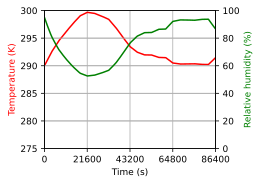

In [20]:
plt.plot(time,temperature,'r')
plt.ylabel('Temperature (K)', color='r')
plt.ylim([275,300])
plt.xticks(np.linspace(0, time[-1], 5))
plt.xlim([0,time[-1]])
plt.xlabel('Time (s)')
plt.twinx()
plt.plot(time,rh*100,'g')
plt.ylabel('Relative humidity (%)', color='g')
plt.ylim([0,100])
show_plot()

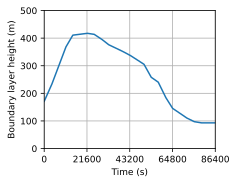

In [21]:
plt.plot(time,height)
plt.xticks(np.linspace(0, time[-1], 5))
plt.xlim([0,time[-1]])
plt.xlabel('Time (s)')
plt.ylim([0,500])
plt.ylabel('Boundary layer height (m)')
show_plot()

In [22]:
def set_tickmarks(axes, n_ticks):
    ylims = axes.get_ylim()
    if np.log10(ylims[0]) > 1:
        val = -int(np.ceil(np.abs(np.log10(ylims[0])))) + 1
    else:
        val = int(np.ceil(np.abs(np.log10(ylims[0])))) + 1     
    ymin = round(ylims[0] - .1 * ylims[0], val)
    ymax = round(ylims[1] + .1 * ylims[1], val)
    plt.ylim([ymin, ymax])
    plt.yticks(np.linspace(ymin, ymax, n_ticks))

In [23]:
#### Evolution of gas-phase species

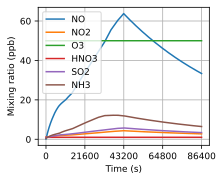

In [24]:
gases = ["NO", "NO2", "O3", "HNO3", "SO2", "NH3"]
for i_spec, spec in enumerate(gases):
    i_spec = gas_data.spec_by_name(spec)
    l, = plt.plot(time, gas_mix_rat[:, i_spec], label=spec)
plt.xlabel("Time (s)")
plt.ylabel("Mixing ratio (ppb)")
plt.xticks(np.linspace(0, time[-1], 5))
plt.legend()
show_plot()

#### Bulk Aerosol Evolution

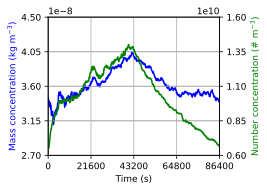

In [25]:
plt.plot(time, mass_conc, "b", label="mass conc")
plt.ylabel("Mass concentration (kg m$^{-3}$)", color='b')
plt.xlabel("Time (s)")
set_tickmarks(plt.gca(), 5)
plt.twinx()
plt.plot(time, num_conc, "g", label="num conc")
plt.xticks(np.linspace(0, time[-1], 5))
plt.xlim([time[0],time[-1]])
set_tickmarks(plt.gca(), 5)
plt.ylabel(r"Number concentration ($\#$ m$^{-3}$)", color='g')
show_plot()

#### Aerosol Size Distribution Evolution

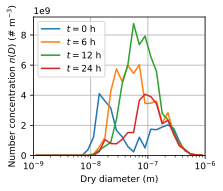

In [26]:
plt.plot(diam_grid.centers, dists[0],label='$t = 0$ h')
plt.plot(diam_grid.centers, dists[6],label='$t = 6$ h')
plt.plot(diam_grid.centers, dists[12],label='$t = 12$ h')
plt.plot(diam_grid.centers, dists[24],label='$t = 24$ h')
plt.xscale("log")
plt.xlabel("Dry diameter (m)")
plt.ylabel(r"Number concentration $n(D)$ ($\#$ m$^{-3}$)")
plt.ylim(bottom=0)
plt.legend()
plt.xlim([diam_grid.edges[0],diam_grid.edges[-1]])
show_plot()

#### Aerosol Mixing State Evolution

While the previous aerosol figures give an overview of aerosol size distribution and composition
just like traditional size-distribution-based models, they do not address the issue of mixing state.
To show how the mixing state evolved over the course of the simulation we display the data,
where the two-dimensional number distribution is plotted as a function of dry diameter and
dry mass fraction of BC.



In [27]:
mass_frac_grid = ppmc.BinGrid(100, "linear", 0, 1)
mass_frac_histogram = []
num_concs = aero_state.num_concs
dry_diameters = aero_state.dry_diameters
bc_masses = aero_state.masses(include=["BC"])
dry_masses = aero_state.masses(exclude=["H2O"])
species_mass_frac = np.array(bc_masses) / np.array(dry_masses)
vals = ppmc.histogram_2d(
    diam_grid, dry_diameters, mass_frac_grid, species_mass_frac, num_concs
)

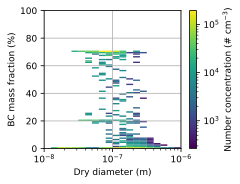

In [28]:
plt.pcolormesh(
    diam_grid.edges,
    np.array(mass_frac_grid.edges)*100,
    np.array(vals).T / 1e6,
    norm=matplotlib.colors.LogNorm(),
)
plt.xscale("log")
plt.xlim([1e-8, 1e-6])
plt.colorbar(label=r"Number concentration ($\#$ cm$^{-3}$)")
plt.xlabel("Dry diameter (m)")
plt.ylabel("BC mass fraction (%)")
show_plot()